In [2]:
import os
import tarfile
import urllib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import hashlib
from sklearn.impute import SimpleImputer
from tqdm import tqdm

# Download the data

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
# fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH) -> pd.DataFrame:
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Load data and split into train and test sets

In [6]:
housing = load_housing_data()
# housing.info()
# housing['total_bedrooms'].describe()
# housing.describe()
# housing.hist(bins=50, figsize=(20,15))
# plt.show()

In [7]:
def split_train_test(data: pd.DataFrame, test_ratio: float = 0.2) -> pd.DataFrame:
    # This function splits the data into training and testing sets.

    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")
# train_set['ocean_proximity'].hist()
# plt.show()
# test_set['ocean_proximity'].hist()
# plt.show()


16512 train + 4128 test


In [8]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio


def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    int_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~int_test_set], data.loc[int_test_set]


In [9]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [10]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [11]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:>

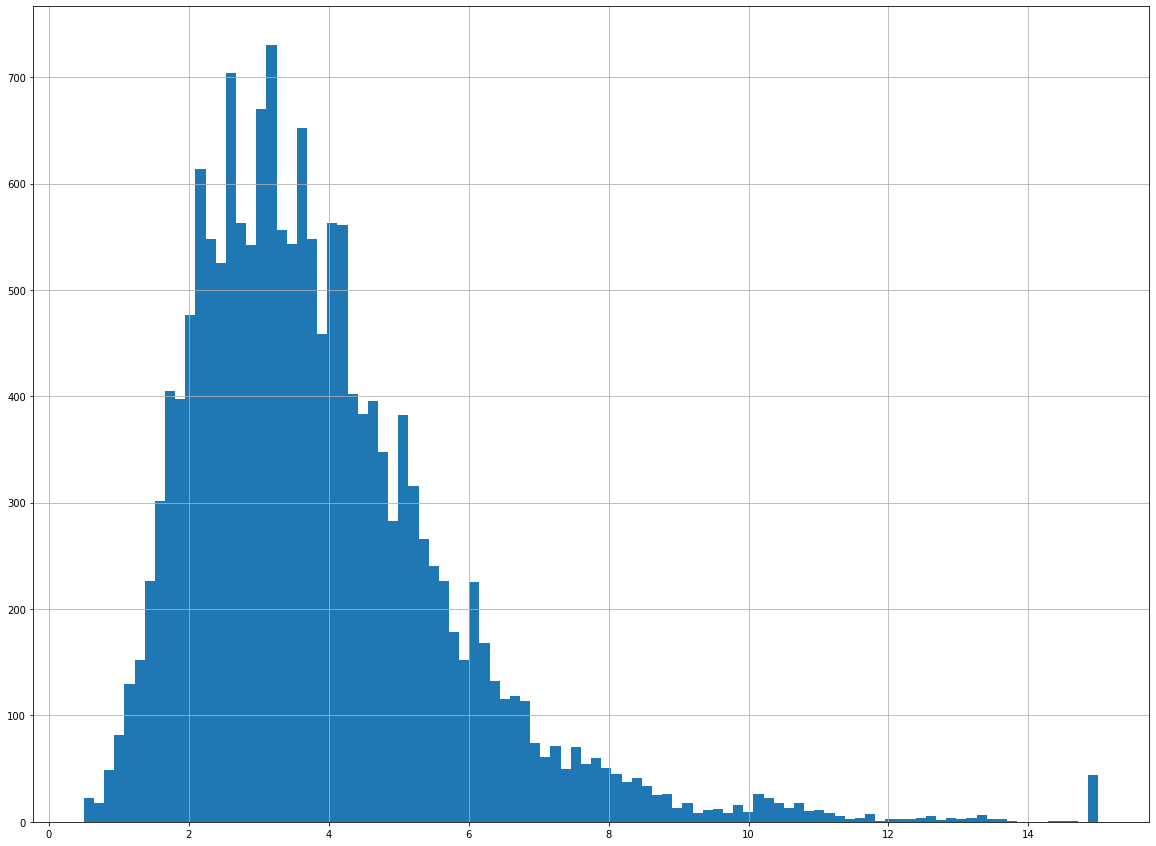

In [12]:
train_set['median_income'].hist(bins=100, figsize=(20,15))

Most median income values are clustered around 2–5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category and do stratified sampling based on the income category. For this we can use ***Scikit-Learn’s*** `StratifiedShuffleSplit` class.

In [13]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
# since the income_cat is no longer required, we can remove this column safely.
for set in tqdm((strat_train_set, strat_test_set)):
    set.drop(['income_cat'], axis=1, inplace=True)

100%|██████████| 2/2 [00:00<00:00, 666.45it/s]


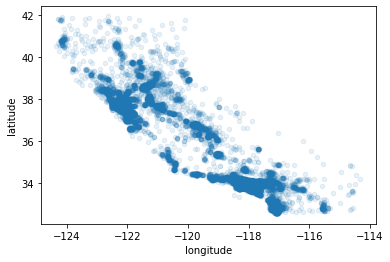

In [16]:
# make a copy of train set. Keep the main training set intact to use it later
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

The radius of each circle represents the district’s population (option s)
the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

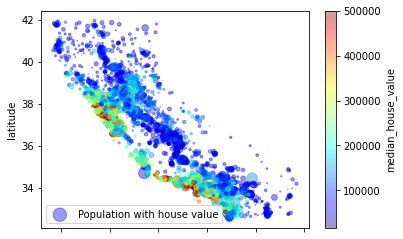

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, c='median_house_value', 
             s=housing['population'] / 100, label='Population with house value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

In [18]:
# find the correlation matrix for the median house value since we are 
# predicting this field.
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use Pandas’ `scatter_matrix` function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 121 plots.

In [19]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(12, 8))
# plt.plot()

Let's zoom in to the most promising one.
This plot reveals a few things. 

1. First, the correlation is indeed very strong; we can clearly see the upward trend and the points are not too dispersed. 
2. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. 

But this plot reveals other less obvious straight lines: 
A horizontal line around 450,000 usd, another around 350,000usd perhaps one around 280,000$ and a few more below that.
We may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.

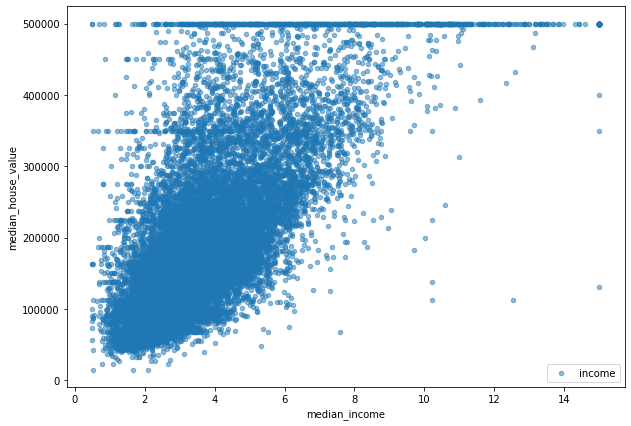

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.5, label="income", figsize=(10, 7))
plt.show()

## Experimenting with Attribute Combinations

In [21]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedroom_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population'] / \
    housing['households']

In [22]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedroom_per_room           -0.259952
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

Let's remove the predictable field **median_house_value** and store it to the `housing` variable. Also, create `housing_labels` and store the **median_house_value** column to use it as label in further.

In [23]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create
a few functions to take care of them. You noticed earlier that the total_bedrooms
attribute has some missing values, so let’s fix this. You have three options:
    
- Get rid of the corresponding districts.
- Get rid of the whole attribute.
- Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s `dropna()`, `drop()`, and `fillna()`
methods:
```
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
```
```
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median) # option 3
```
If you choose option 3, you should compute the median value on the training set, and
use it to fill the missing values in the training set, but also don’t forget to save the
median value that you have computed. You will need it later to replace missing values
in the test set when you want to evaluate your system, and also once the system goes
live to replace missing values in new data.
Scikit-Learn provides a handy class to take care of missing values: `Imputer`. Here is
how to use it. First, you need to create an Imputer instance, specifying that you want
to replace each attribute’s missing values with the median of that attribute:

In [24]:
imputer = SimpleImputer(strategy="median")

# Since the median can only be computed on numerical attributes, we need to create a
# copy of the data without the text attribute ocean_proximity:

housing_num = housing.drop("ocean_proximity", axis=1)

Now we can fit the imputer instance to the training data using the `fit()` method. The `imputer` has simply computes the median of each attribute and stores the result
in its `statistics_` instance variable. Only the `total_bedrooms` attribute had missing
values, but we cannot be sure that there won’t be any missing values in new data after
the system goes live, so it is safer to apply the imputer to all the numerical attributes

In [25]:
# calculating median using SK-Learns SimpleImputer
imputer.fit(housing_num)
print(imputer.statistics_)
# calculating median using pandas
print(housing_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [26]:
"""
Now we can use this “trained” imputer to transform the training set by replacing
missing values by the learned medians. 
"""
x = imputer.transform(housing_num)
print(type(x))
"""
The result is a plain Numpy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple:
"""
housing_tr = pd.DataFrame(x, columns=housing_num.columns)
housing_tr.head()

<class 'numpy.ndarray'>


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


# Handling Text and Categorical Attributes

Earlier we left out the categorical attribute ocean_proximity because it is a text
attribute so we cannot compute its median. Most Machine Learning algorithms pre‐
fer to work with numbers anyway, so let’s convert these text labels to numbers.
Scikit-Learn provides a transformer for this task called `LabelEncoder`.

In [45]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"] # ocean proximity is a text attribute
housing_cat_encoded = encoder.fit_transform(housing_cat)

print("Encoder Classes: ", encoder.classes_)
# visualize the encoded data
encoded_non_encoded_dict = dict()
encoded_non_encoded_dict["housing_cat_encoded"] = housing_cat_encoded[:10]
encoded_non_encoded_dict["housing"] = housing["ocean_proximity"].values[:10]
print(pd.DataFrame(encoded_non_encoded_dict))


Encoder Classes:  ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
   housing_cat_encoded     housing
0                    1      INLAND
1                    4  NEAR OCEAN
2                    1      INLAND
3                    4  NEAR OCEAN
4                    0   <1H OCEAN
5                    3    NEAR BAY
6                    0   <1H OCEAN
7                    0   <1H OCEAN
8                    0   <1H OCEAN
9                    0   <1H OCEAN


One issue with this representation is that ML algorithms will assume that two nearby
values are more similar than two distant values. Obviously this is not the case (for
example, categories 0 and 4 are more similar than categories 0 and 1). To fix this
issue, a common solution is to create one binary attribute per category: one attribute
equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute
equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is
called one-hot encoding, because only one attribute will be equal to 1 (hot), while the
others will be 0 (cold).
Scikit-Learn provides a `OneHotEncoder` encoder to convert integer categorical values
into one-hot vectors.

In [43]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))

"""
NumPy's reshape() function allows one dimension to be -1, which means "unspecified": the value is inferred
from the length of the array and the remaining dimensions.
"""

print(housing_cat_1hot.dtype)

float64


We can use the `LabelBinarizer` to convert text labels to 1-hot vectors directly.

In [50]:
from sklearn.preprocessing import LabelBinarizer
# set the sparse_output=True to return a sparse matrix and save memory.
# The default is to return a dense matrix.
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>